# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [2]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import gc
import pickle as pkl

# Data manipulation
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf, erfinv
import scipy.stats as stats
from scipy.integrate import quad
from scipy.signal import savgol_filter
from scipy import fftpack
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
import matplotlib.pylab as plb

# From alens_analysis.py
import alens_analysis as aa
from alens_analysis.colormaps import register_cmaps
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
import alens_analysis.chromatin.chrom_poly_stats as cps
import alens_analysis.helpers as ahlp
from alens_analysis import cluster_analysis as cla

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'
cond_path = Path.home() / 'ceph/DATA/Chromatin/CondCharPaper'

cuda


In [3]:
torch.__version__

import warnings

warnings.filterwarnings('ignore')

'1.13.0'

### Style settings

In [4]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

register_cmaps()
plt.rcParams['image.cmap'] = 'YlOrRd'
#plt.rcParams['image.cmap'] = 'emct8'
#plt.rcParams['image.cmap'] = 'warm'
#plt.rcParams['image.cmap'] = 'twilight'
#plt.rcParams['image.cmap'] = 'coolwarm'
#plt.rcParams['image.cmap'] = 'RdYlBu_r'
        

# Functions

In [5]:
def collapse_graph_func(fig, axarr, data_path, param_str, label_str,
                        ss_ind=1,
                        end_ind=-1,
                        start_bead=0,
                        end_bead=None):
    try:
        axarr[0].sharey(axarr[1])
        axarr[0].sharex(axarr[1])
        mp = re.compile(f'{param_str}(\d*\.?\d+)')

        param_dirs = sorted(
            [pd for pd in data_path.glob('*/')],
            key=lambda x: float(mp.match(str(x.name))[1]))

        param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]
        log_pvs = np.log10(param_vals)
        log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
        colors = plb.cm.plasma(log_pvs)

        avg_rog_list = []
        std_rog_list = []
        for i, pd in enumerate(param_dirs):
            avg_rog_arrs = []
            sd_h5_data_lst = []
            for h5p in pd.glob('s*/analysis/raw*.h5'):
                try:
                    sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
                except:
                    print(f'Could not open {h5p}.')
            if len(sd_h5_data_lst) == 0:
                continue

            for h5_data in sd_h5_data_lst:
                # Get data from h5 file
                time_arr = h5_data['time'][ss_ind:end_ind]
                sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                          :, ss_ind:end_ind]
                com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
                n_beads = com_arr.shape[0]

                rog = aa.calc_rad_of_gyration(com_arr)
                _ = axarr[0].plot(time_arr, rog, color=colors[i], alpha=.1)
                avg_rog_arrs += [rog.tolist()]
            min_length = min([len(avg) for avg in avg_rog_arrs])

            avg_rog_arrs = np.array([avg[:min_length] for avg in avg_rog_arrs])
            avg_rog_list += [avg_rog_arrs.mean(axis=0)]
            std_rog_list += [avg_rog_arrs.std(axis=0)]

            label = re.split(r'(^[^\d]+)', str(pd.name))[1:][1]
            for h5d in sd_h5_data_lst:
                h5d.close()

            _ = axarr[1].plot(time_arr[:min_length], avg_rog_list[-1],
                              color=colors[i], label=f"{label_str}$= {label}$")

        _ = axarr[0].set_ylabel('Radius of gyration\n' + r'$R_g$ ($\mu$m)')
        _ = axarr[0].set_xlabel('Time (sec)')
        _ = axarr[1].set_xlabel('Time (sec)')
        _ = axarr[0].set_yscale('log')
        _ = axarr[1].axhline(0.486918, c='k')

        _ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
        fig.tight_layout()

    except:
        raise
    finally:
        for h5d in sd_h5_data_lst:
            h5d.close()


In [6]:
def collapse_graph_func_ci(fig, ax, data_path, param_str, label_str,
                           ci_bound=.95,
                           ss_ind=1,
                           end_ind=-1,
                           start_bead=0,
                           end_bead=None):
    try:
        mp = re.compile(f'{param_str}(\d*\.?\d+)')

        param_dirs = sorted(
            [pd for pd in data_path.glob('*/')],
            key=lambda x: float(mp.match(str(x.name))[1]))

        param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]
        log_pvs = np.log10(param_vals)
        log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
        colors = plb.cm.plasma(log_pvs)

        avg_rog_list = []
        std_rog_list = []
        for i, pd in enumerate(param_dirs):
            avg_rog_arrs = []
            sd_h5_data_lst = []
            for h5p in pd.glob('s*/analysis/raw*.h5'):
                try:
                    sd_h5_data_lst += [h5py.File(h5p, 'r')]
                except:
                    print(f'Could not open {h5p}.')
            if len(sd_h5_data_lst) == 0:
                continue

            for h5_data in sd_h5_data_lst:
                # Get data from h5 file
                time_arr = h5_data['time'][ss_ind:end_ind]
                sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                          :, ss_ind:end_ind]
                com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
                n_beads = com_arr.shape[0]

                rog = aa.calc_rad_of_gyration(com_arr)
                avg_rog_arrs += [rog.tolist()]
            min_length = min([len(avg) for avg in avg_rog_arrs])

            avg_rog_arrs = np.array([avg[:min_length] for avg in avg_rog_arrs])
            avg_rog_list += [avg_rog_arrs.mean(axis=0)]
            std_rog_list += [avg_rog_arrs.std(axis=0)]

            label = re.split(r'(^[^\d]+)', str(pd.name))[1:][1]
            for h5d in sd_h5_data_lst:
                h5d.close()

            _ = ax.plot(time_arr[:min_length], avg_rog_list[-1],
                        color=colors[i], label=f"{label_str}$= {label}$")
            ci = ((std_rog_list[-1]/np.sqrt(avg_rog_arrs.shape[0])) *
                  (np.sqrt(2)*erfinv(ci_bound)))
            _ = ax.fill_between(time_arr[:min_length], (avg_rog_list[-1] - ci),
                                (avg_rog_list[-1] + ci), 
                                color=colors[i], alpha=.25)

        _ = ax.axhline(0.486918, c='k', linestyle=':', linewidth=4, label='SAW $R_g$')
        _ = ax.set_ylabel('Radius of gyration\n' + r'$R_g$ ($\mu$m)')
        _ = ax.set_xlabel('Time (sec)')
        _ = ax.set_yscale('log')

        _ = ax.legend(loc='center left', bbox_to_anchor=(1.05, .5))

    except:
        raise
    finally:
        for h5d in sd_h5_data_lst:
            h5d.close()


In [7]:
def collapse_size_phase_diagram(fig, axarr, dpath_list,
                                p1_key_list, p2_key_list,
                                ss_ind=0,
                                end_ind=-1,
                                start_bead=0,
                                end_bead=None,
                                ss_rog_avg_start_ind=-600, 
                                scale_mark_size=True
                                ):

    # Get all directories that hold seed directories with all other parameters the same
    param_dirs = [
        pd for data_path in dpath_list for pd in data_path.glob('*/')]
    axarr[0].sharey(axarr[1])
    axarr[0].sharex(axarr[1])

    try:
        # Get average values
        collapse_times_avg = []
        collapse_times_std = []
        rog_avg = []
        rog_std = []

        p1_val_list = []
        p2_val_list = []
        for i, pd in tqdm(enumerate(param_dirs)):
            sd_h5_data_lst = []
            rog_arr = []
            for h5p in pd.glob('s*/analysis/raw*.h5'):
                try:
                    sd_h5_data_lst += [h5py.File(h5p, 'r')]
                except:
                    print(f'Could not open {h5p}.')
            if len(sd_h5_data_lst) == 0:
                continue
            clps_times = []

            # Extract parameters of interest from yaml files
            prot_params = yaml.safe_load(
                sd_h5_data_lst[0].attrs['ProteinConfig'])

            # Proteins don't always have the same level of keys.
            # Loop of dictionary structure to get the values for each param
            p1 = prot_params['proteins'][0]
            for key in p1_key_list:
                p1 = p1[key]
            p1_val_list += [p1]

            p2 = prot_params['proteins'][0]
            for key in p2_key_list:
                p2 = p2[key]
            p2_val_list += [p2]

            for h5_data in sd_h5_data_lst:
                time_arr = h5_data['time'][ss_ind:end_ind]
                sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                          :, ss_ind:end_ind]
                com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
                rog = aa.calc_rad_of_gyration(com_arr)
                clps_ind = ahlp.find_steady_state_ind(
                    rog, [ss_rog_avg_start_ind, None])
                clps_times += [time_arr[clps_ind]]
                rog_arr += [rog[clps_ind:].mean()]

            rog_avg += [np.mean(rog_arr)]
            rog_std += [np.std(rog_arr)]
            collapse_times_avg += [np.mean(clps_times)]
            collapse_times_std += [np.std(clps_times)]

        collapse_times_avg = np.array(collapse_times_avg)
        collapse_times_std = np.array(collapse_times_std)
        rog_avg = np.array(rog_avg)
        rog_std = np.array(rog_std)

        clps_size = 500*np.sqrt(collapse_times_std/collapse_times_avg) if scale_mark_size else 200
        _ = axarr[0].scatter(p1_val_list, p2_val_list,
                             c=mpl.cm.plasma(
                                 collapse_times_avg/np.max(collapse_times_avg)),
                             s=clps_size,
                             marker='s')
        cb0 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=np.max(collapse_times_avg)),
                                                 cmap='plasma'),
                           ax=axarr[0])
        _ = cb0.set_label('Mean collapse time (sec)')

        rog_size = 1000*np.sqrt(rog_std)/rog_avg if scale_mark_size else 200
        _ = axarr[1].scatter(p1_val_list, p2_val_list,
                             c=mpl.cm.plasma(rog_avg/np.max(rog_avg)),
                             s=rog_size,
                             marker='s')
        cb1 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=np.max(rog_avg)),
                                                 cmap='plasma'),
                           ax=axarr[1])
        _ = cb1.set_label('Mean steady-state RoG ($\mu$m)')

    except:
        raise
    finally:
        for h5d in sd_h5_data_lst:
            h5d.close()
    return (p1_val_list, p2_val_list, collapse_times_avg, collapse_times_std, rog_avg, rog_std)


# Data

In [8]:
data_dir_list = {
cond_path /"22-09_aLc1_scan6.12_line200-6400_sticky_runs/simulations", 
cond_path /"22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations", 
cond_path /"22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations", 
cond_path /"22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07/simulations", 
cond_path /"22-11-23_aLchr1_scan8.12_line800_Ke50_Ls55nm_kod.1-300/simulations", 
cond_path /"22-11-23_aLchr1_scan8.12_line800_sticky20nm_kod3_Ke1-200/simulations", 
cond_path /"22-11-23_aLchr1_scan7.12_line800_sticky10-70nm_kod3_Ke5/simulations", 
cond_path /"22-11-23_aLchr1_scan8.12_line800_Ke10_Ls55nm_kod.1-300/simulations", 
cond_path /"22-12-08_aLchr1_scan7.12_Ke30_kod3.05_line800_2xLs.01-.07/simulations", 
cond_path /"22-12-08_aLchr1_scan8.12_line800_2xLs55nm_kod3_Ke1-200/simulations", 
}

running_dir_list = {
cond_path /"22-12-07_aLchr1_scan8.12_line800_Ls55nm_kod3_Ke1-200/simulations", 
cond_path /"22-12-08_aLchr1_scan8.12_line800_Ls0.1-0.7_kod3_Ke1-200/simulations"
}

# Figures

## Ke scans

Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s12/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s7/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s4/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s3/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s6/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke10/s4/analysis/raw_tmp.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


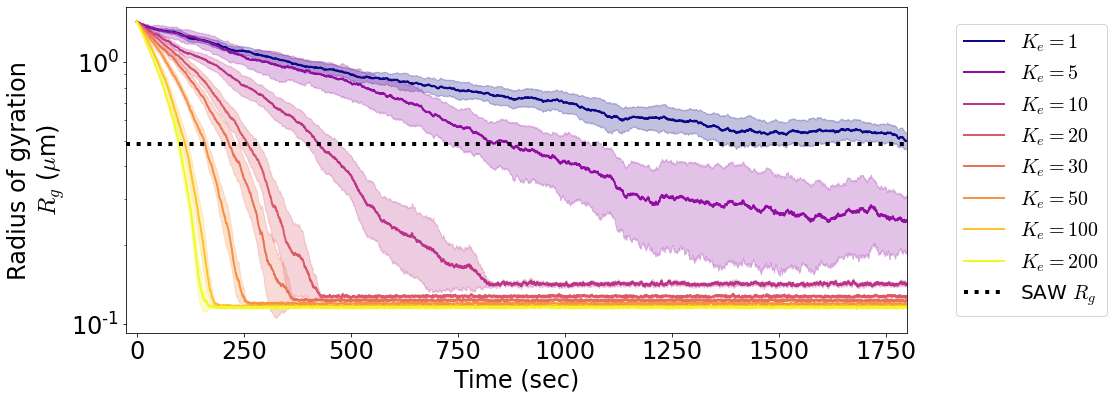

In [7]:
data_path = (ceph_path / "CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations")
fig, ax = plt.subplots(figsize=(14, 6))
collapse_graph_func_ci(fig, ax, data_path, "Ke", "$K_e$",
                    ci_bound = .95,
                    ss_ind=1,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )
_ = ax.set_xlim(-25, 1800)

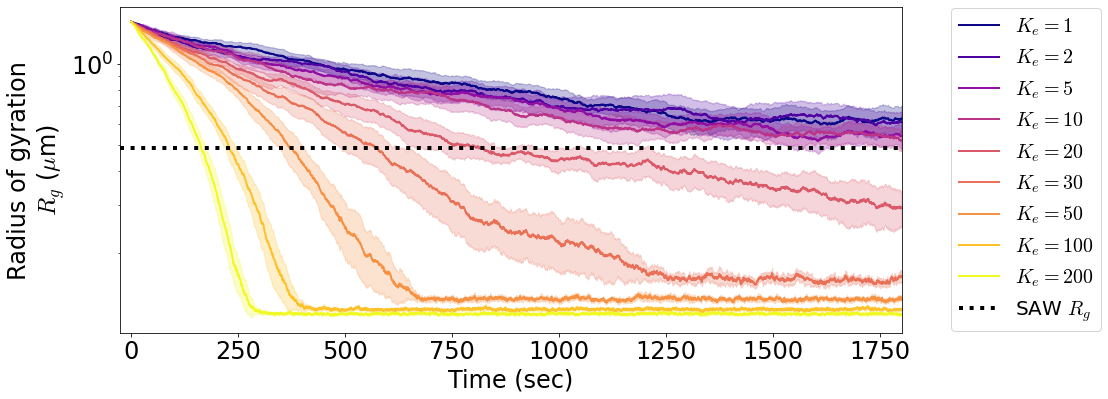

In [8]:
data_path = (cond_path / "22-11-23_aLchr1_scan8.12_line800_sticky20nm_kod3_Ke1-200/simulations")
fig, ax = plt.subplots(figsize=(14, 6))
collapse_graph_func_ci(fig, ax, data_path, "Ke", "$K_e$",
                    ci_bound = .95,
                    ss_ind=1,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )
_ = ax.set_xlim(-25, 1800)

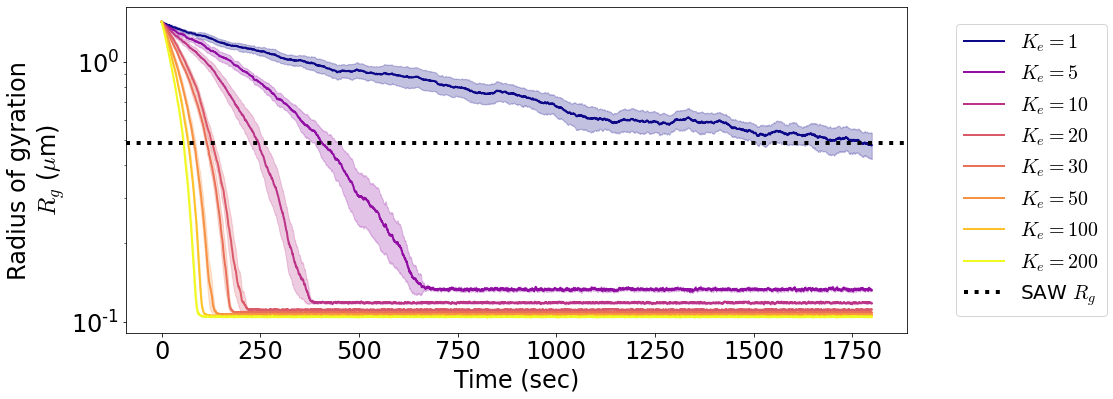

In [20]:
data_path = ( cond_path /"22-12-08_aLchr1_scan8.12_line800_2xLs55nm_kod3_Ke1-200/simulations")
fig, ax = plt.subplots(figsize=(14, 6))
collapse_graph_func_ci(fig, ax, data_path, "Ke", "$K_e$",
                    ci_bound = .95,
                    ss_ind=1,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )
# _ = ax.set_xlim(-25, 1800)

## $\ell_s$ scans

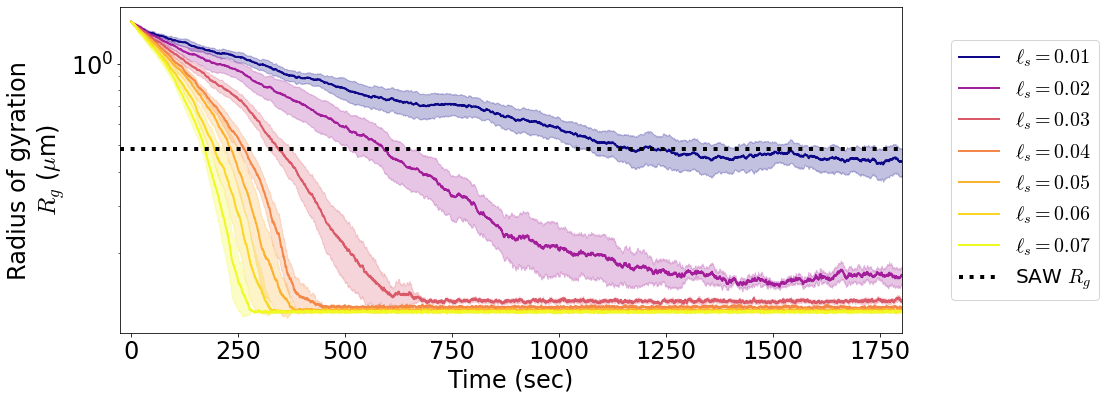

In [9]:
data_path = (ceph_path / "CondCharPaper/22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07/simulations")
fig, ax = plt.subplots(figsize=(14, 6))
collapse_graph_func_ci(fig, ax, data_path, "Ls", "$\ell_s$",
                    ci_bound = .95,
                    ss_ind=1,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )
_ = ax.set_xlim(-25, 1800)

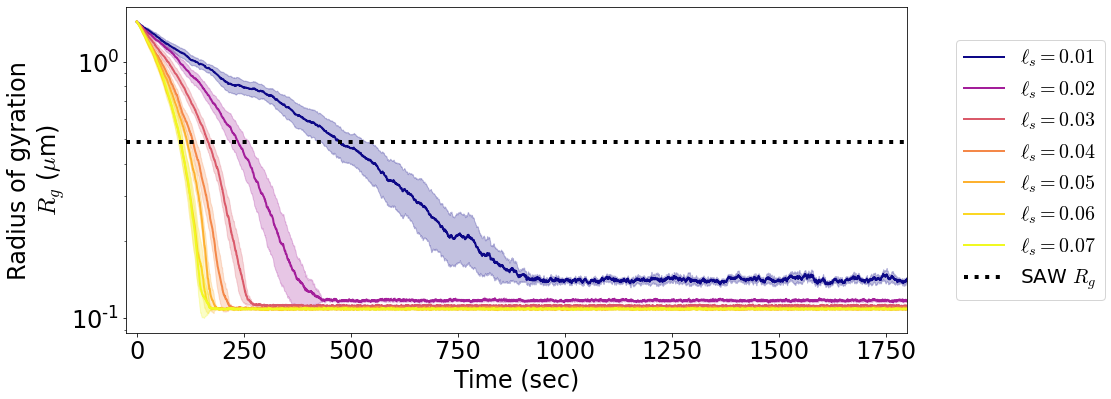

In [10]:
data_path = (ceph_path / "CondCharPaper/22-12-08_aLchr1_scan7.12_line800_Ke30_kod3.05_2xLs.01-.07/simulations")
fig, ax = plt.subplots(figsize=(14, 6))
collapse_graph_func_ci(fig, ax, data_path, "Ls", "$\ell_s$",
                    ci_bound = .95,
                    ss_ind=1,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )
_ = ax.set_xlim(-25, 1800)

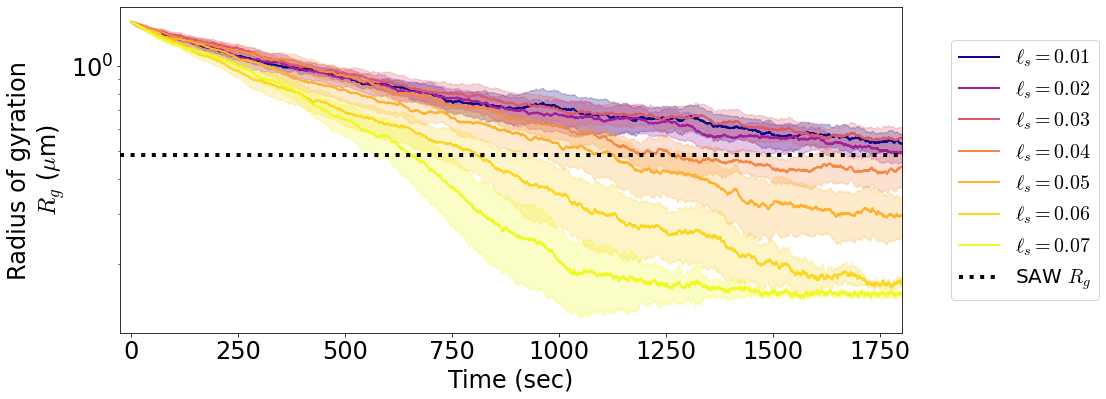

In [11]:
data_path = ( cond_path /"22-11-23_aLchr1_scan7.12_line800_sticky10-70nm_kod3_Ke5/simulations") 
fig, ax = plt.subplots(figsize=(14, 6))
collapse_graph_func_ci(fig, ax, data_path, "Ls", "$\ell_s$",
                    ci_bound = .95,
                    ss_ind=1,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )
_ = ax.set_xlim(-25, 1800)

## $k_o$ scans

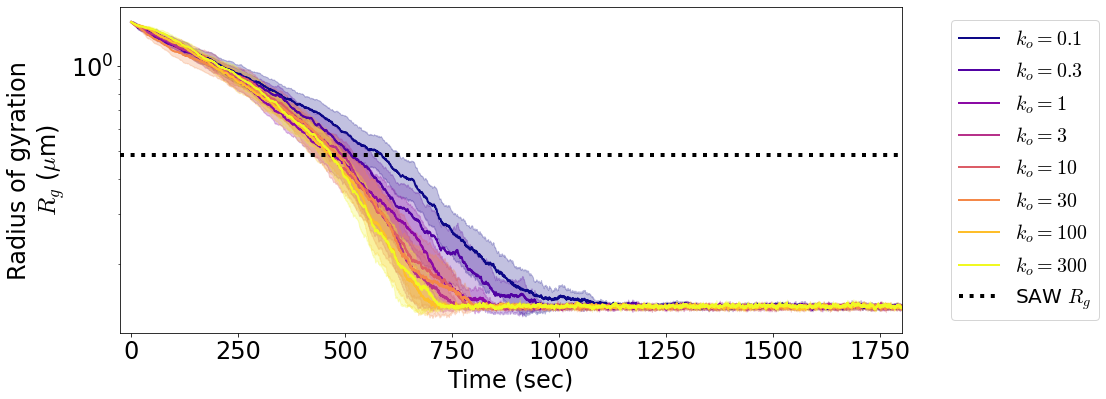

In [19]:
data_path = ( cond_path / "22-11-23_aLchr1_scan8.12_line800_Ke10_Ls55nm_kod.1-300/simulations") 
fig, ax = plt.subplots(figsize=(14, 6))
collapse_graph_func_ci(fig, ax, data_path, "kod", "$k_o$",
                    ci_bound = .95,
                    ss_ind=1,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )
_ = ax.set_xlim(-25, 1800)

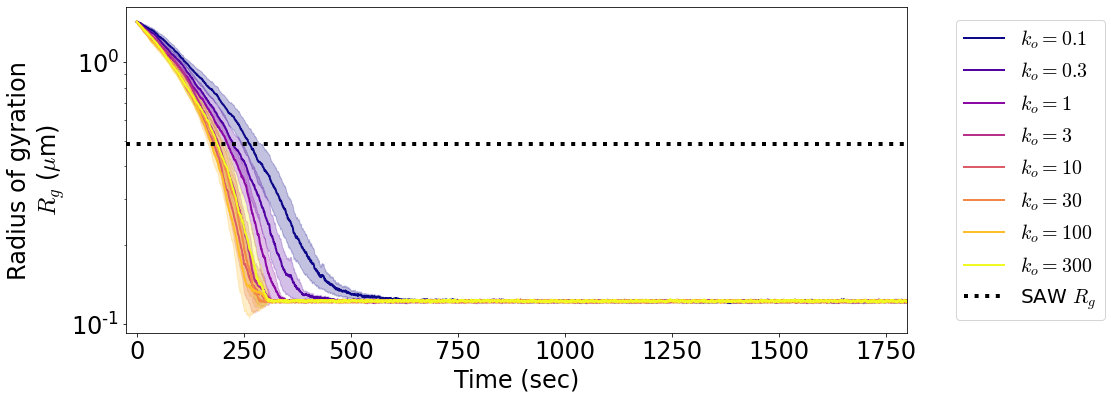

In [15]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
fig, ax = plt.subplots(figsize=(14, 6))
collapse_graph_func_ci(fig, ax, data_path, "kod", "$k_o$",
                    ci_bound = .95,
                    ss_ind=1,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )
_ = ax.set_xlim(-25, 1800)

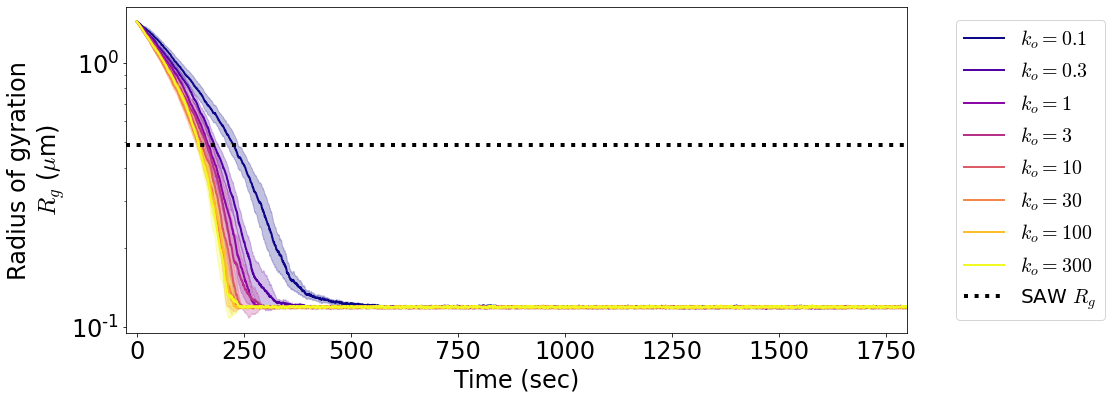

In [16]:
data_path = ( cond_path / "22-11-23_aLchr1_scan8.12_line800_Ke50_Ls55nm_kod.1-300/simulations") 
fig, ax = plt.subplots(figsize=(14, 6))
collapse_graph_func_ci(fig, ax, data_path, "kod", "$k_o$",
                    ci_bound = .95,
                    ss_ind=1,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )
_ = ax.set_xlim(-25, 1800)

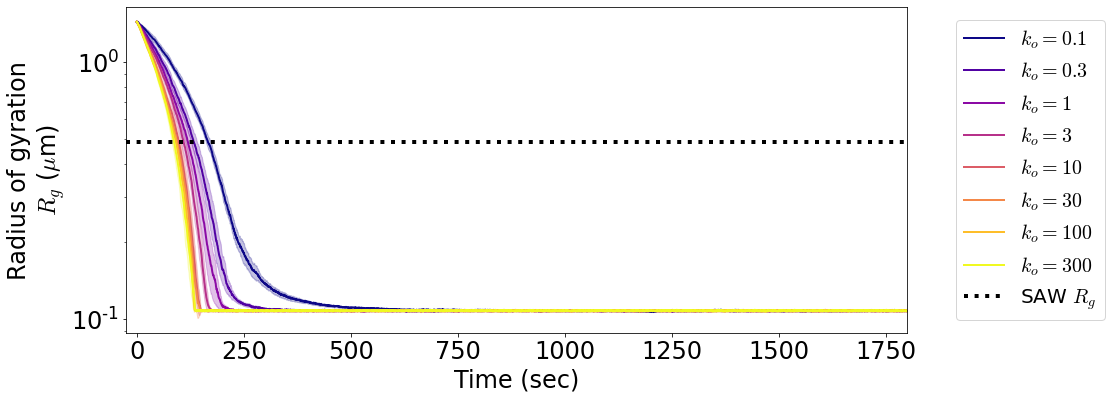

In [17]:
data_path = (cond_path /"22-12-08_aLchr1_scan8.12_line800_Ke30_2xLs55nm_kod.1-300/simulations") 
fig, ax = plt.subplots(figsize=(14, 6))
collapse_graph_func_ci(fig, ax, data_path, "kod", "$k_o$",
                    ci_bound = .95,
                    ss_ind=1,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )
_ = ax.set_xlim(-25, 1800)

# Individual runs

Text(0.5, 1.0, 'Short crosslinkers (20 nm), $K_e$ scan')

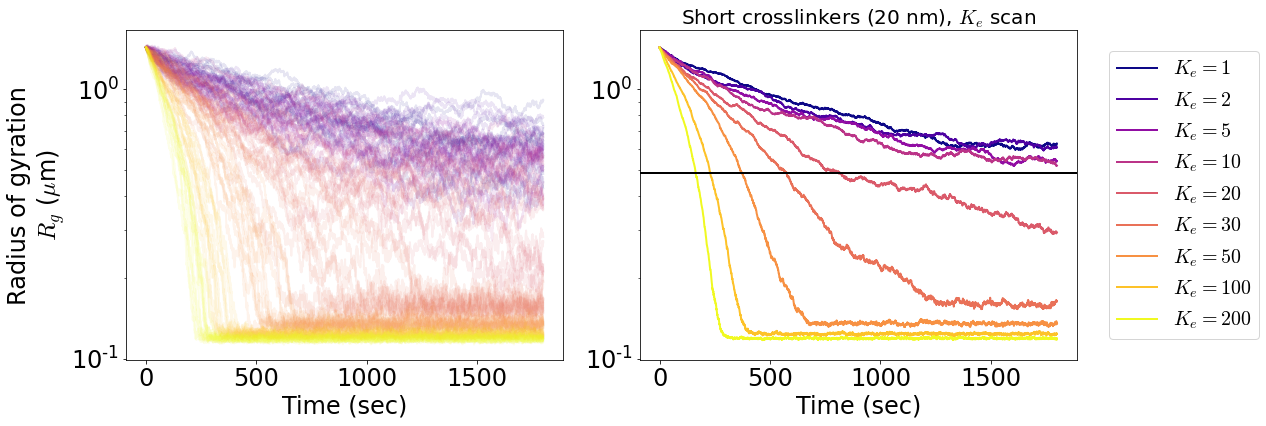

In [17]:
data_path = (
    ceph_path / "CondCharPaper/22-11-23_aLchr1_scan8.12_line800_sticky20nm_kod3_Ke1-200/simulations")
fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
collapse_graph_func(fig, axarr, data_path, "Ke", "$K_e$",
                    ss_ind=1,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )
axarr[1].set_title("Short crosslinkers (20 nm), $K_e$ scan")

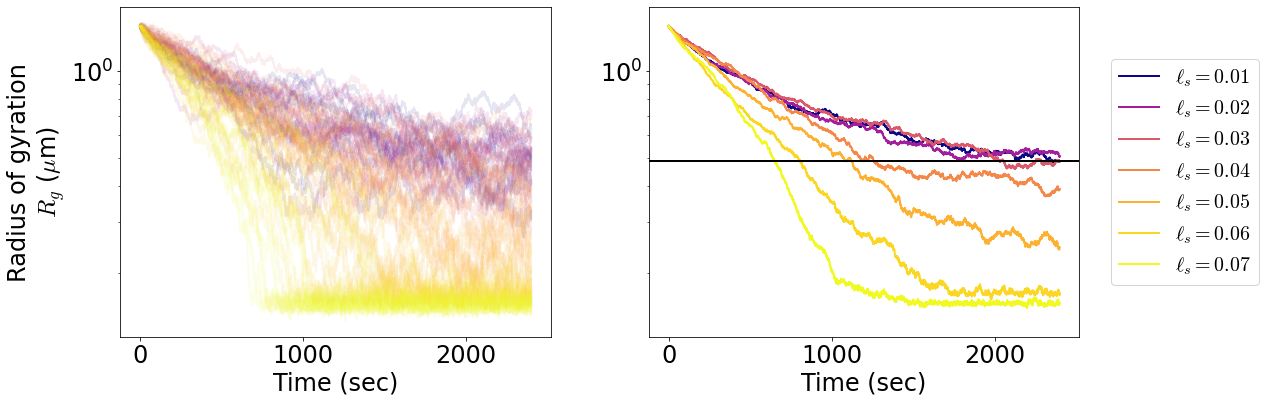

In [18]:
data_path = (
    ceph_path / "CondCharPaper/22-11-23_aLchr1_scan7.12_line800_sticky10-70nm_kod3_Ke5/simulations")
fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
collapse_graph_func(fig, axarr, data_path, "Ls", "$\ell_s$",
                    ss_ind=1,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )

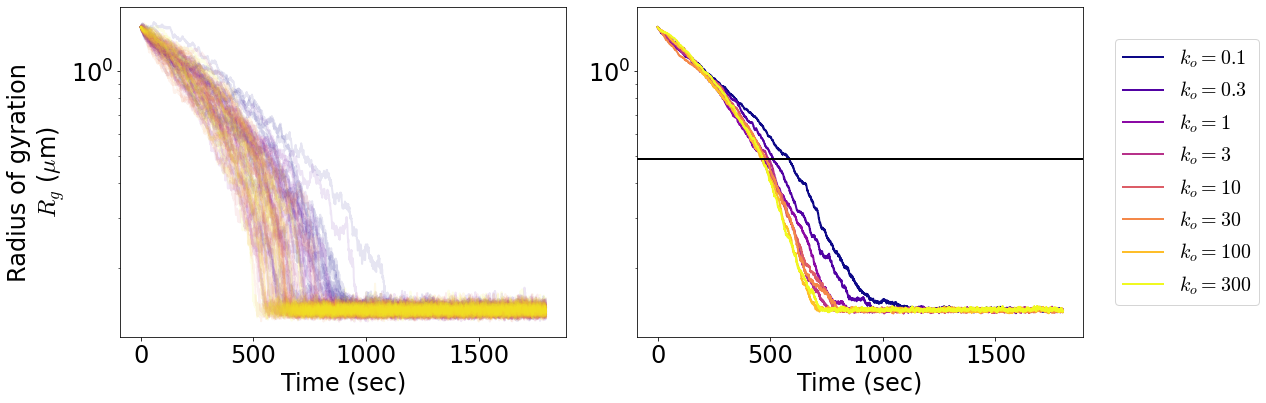

In [19]:
data_path = (
    ceph_path / "CondCharPaper/22-11-23_aLchr1_scan8.12_line800_Ke10_Ls55nm_kod.1-300/simulations")
fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
collapse_graph_func(fig, axarr, data_path, "kod", "$k_o$",
                    ss_ind=1,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )

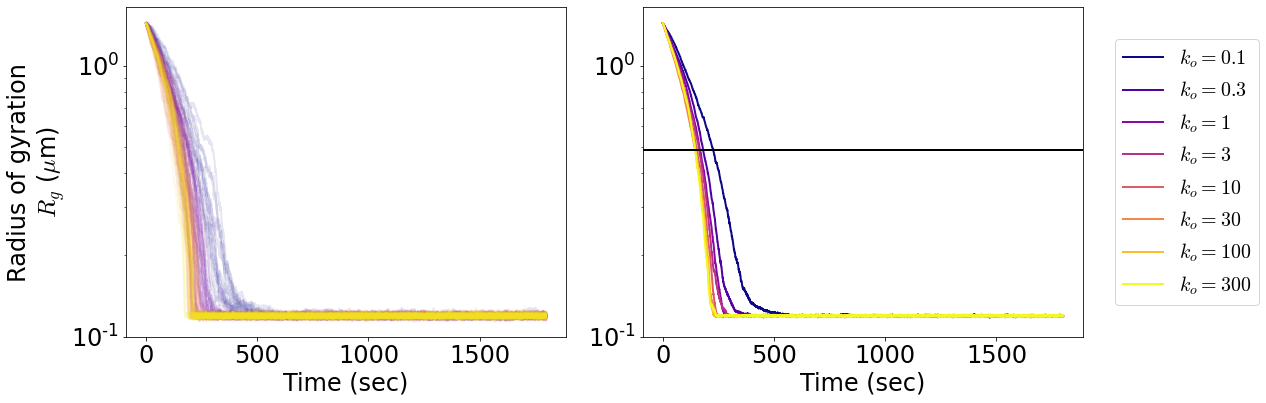

In [20]:
data_path = (
    ceph_path / "CondCharPaper/22-11-23_aLchr1_scan8.12_line800_Ke50_Ls55nm_kod.1-300/simulations")
fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
collapse_graph_func(fig, axarr, data_path, "kod", "$k_o$",
                    ss_ind=1,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )

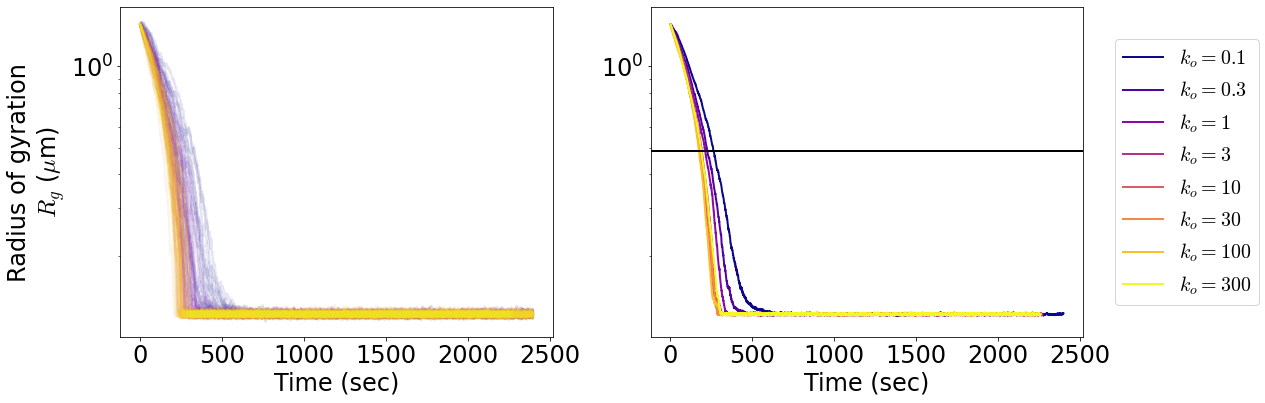

In [21]:
data_path = (
    ceph_path / "CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
collapse_graph_func(fig, axarr, data_path, "kod", "$k_o$",
                    ss_ind=1,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )
# axarr[0].set_xlim(-100, 1800)

## $K_e$ scans

Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s12/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s7/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s4/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s3/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s6/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke10/s4/analysis/raw_tmp.

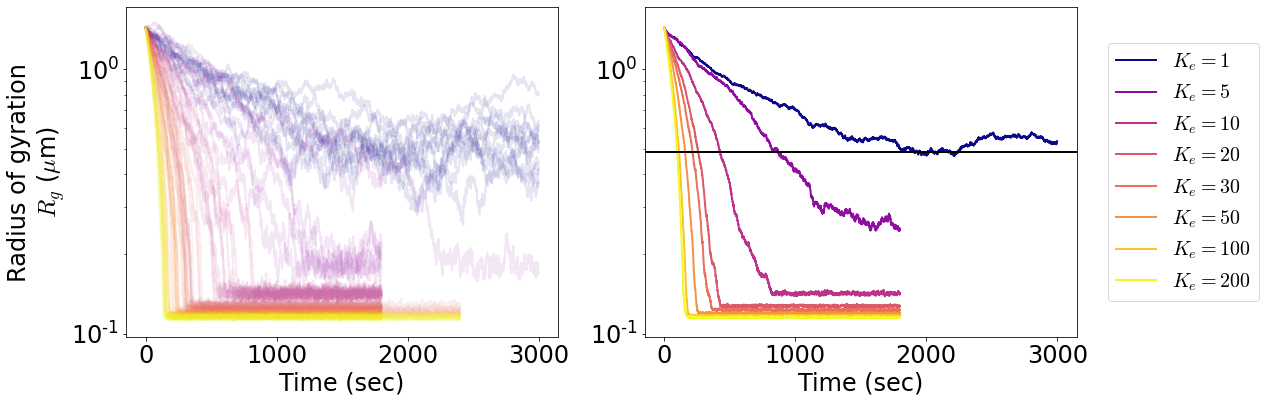

In [22]:
data_path = (
    ceph_path / "CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations")
fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
collapse_graph_func(fig, axarr, data_path, "Ke", "$K_e$",
                    ss_ind=1,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )

Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s12/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s7/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s4/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s3/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s6/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke10/s4/analysis/raw_tmp.

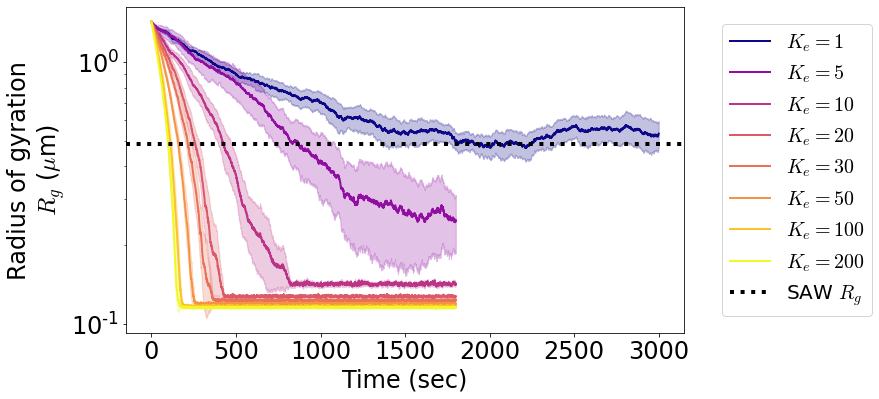

In [23]:
data_path = (
    ceph_path / "CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations")
fig, ax = plt.subplots(figsize=(10, 6))
collapse_graph_func_ci(fig, ax, data_path, "Ke", "$K_e$",
                    ci_bound = .95,
                    ss_ind=1,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )

# $K_e$ and $\ell_s$ Phase diagram

0it [00:00, ?it/s]

Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke20/s11/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke20/s3/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke100/s11/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke30/s9/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s12/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s7/analysis/ra

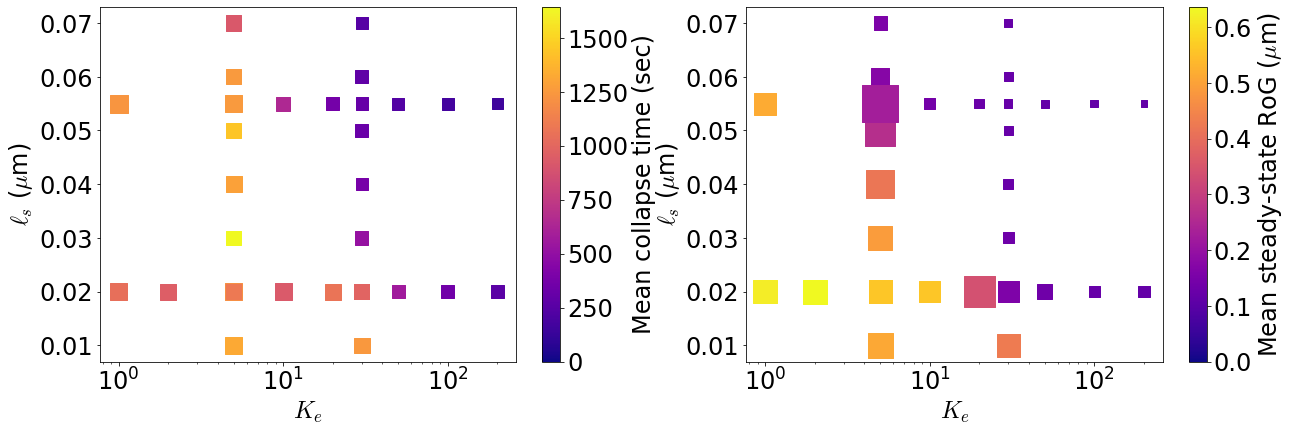

In [24]:
dpath_list = (ceph_path / "CondCharPaper/22-11-23_aLchr1_scan7.12_line800_sticky10-70nm_kod3_Ke5/simulations", 
              ceph_path / "CondCharPaper/22-11-23_aLchr1_scan8.12_line800_sticky20nm_kod3_Ke1-200/simulations",
              ceph_path / "CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations",
              ceph_path / "CondCharPaper/22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07/simulations")
ss_ind = 0
end_ind = -1
start_bead = 0
end_bead = None
ss_rog_avg_start_ind = -600
fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
data = collapse_size_phase_diagram(fig, axarr, dpath_list, 
                            ['Ke', 1], ['freeLength'] )

axarr[0].set_xscale('log')
fig.tight_layout()
for ax in axarr:
    _ = ax.set_xlabel('$K_e$')
    _ = ax.set_ylabel('$\ell_s$ ($\mu$m)')


0it [00:00, ?it/s]

Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke20/s11/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke20/s3/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke100/s11/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke30/s9/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s12/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s7/analysis/ra

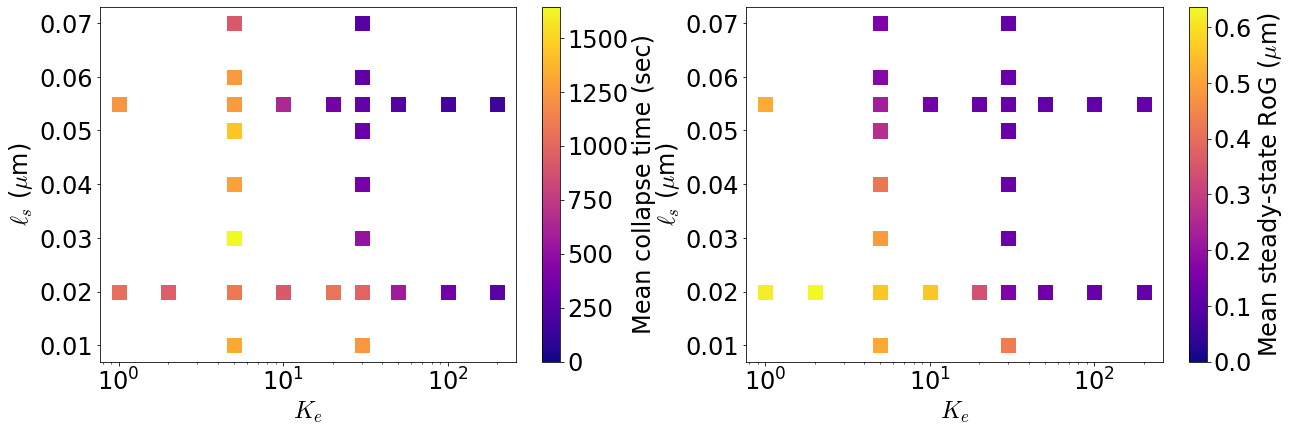

In [25]:
dpath_list = (ceph_path / "CondCharPaper/22-11-23_aLchr1_scan7.12_line800_sticky10-70nm_kod3_Ke5/simulations", 
              ceph_path / "CondCharPaper/22-11-23_aLchr1_scan8.12_line800_sticky20nm_kod3_Ke1-200/simulations",
              ceph_path / "CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations",
              ceph_path / "CondCharPaper/22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07/simulations")
ss_ind = 0
end_ind = -1
start_bead = 0
end_bead = None
ss_rog_avg_start_ind = -600
fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
data = collapse_size_phase_diagram(fig, axarr, dpath_list, 
                            ['Ke', 1], ['freeLength'], scale_mark_size=False)

axarr[0].set_xscale('log')
fig.tight_layout()
for ax in axarr:
    _ = ax.set_xlabel('$K_e$')
    _ = ax.set_ylabel('$\ell_s$ ($\mu$m)')


In [9]:
dpath_list = [cond_path /"22-12-08_aLchr1_slice8.8.12_line800_Ls0.1-0.7_kod3_Ke1-200/simulations",
              ceph_path / "CondCharPaper/22-11-23_aLchr1_scan7.12_line800_sticky10-70nm_kod3_Ke5/simulations", 
              ceph_path / "CondCharPaper/22-11-23_aLchr1_scan8.12_line800_sticky20nm_kod3_Ke1-200/simulations",
              ceph_path / "CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations",
              ceph_path / "CondCharPaper/22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07/simulations"]
ss_ind = 0
end_ind = -1
start_bead = 0
end_bead = None
ss_rog_avg_start_ind = -600
fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
data = collapse_size_phase_diagram(fig, axarr, dpath_list, 
                            ['Ke', 1], ['freeLength'], scale_mark_size=False)

axarr[0].set_xscale('log')
for ax in axarr:
    _ = ax.set_xlabel('$K_e$')
    _ = ax.set_ylabel('$\ell_s$ ($\mu$m)')

fig.tight_layout()


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke20/s11/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke20/s3/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke100/s11/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke30/s9/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s12/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s7/analysis/ra

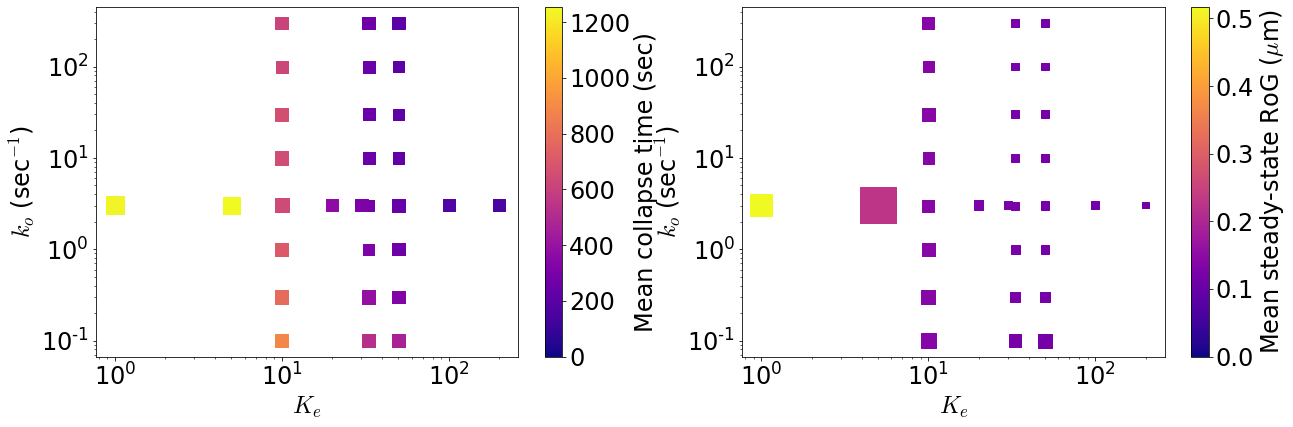

In [23]:
dpath_list = (ceph_path / "CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations", 
              )
ss_ind = 0
end_ind = -1
start_bead = 0
end_bead = None
ss_rog_avg_start_ind = -600
fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
data = collapse_size_phase_diagram(fig, axarr, dpath_list,
                                   ['Ke', 1], ['ko_d', 1] )

fig.tight_layout()
axarr[0].set_xscale('log')
axarr[0].set_yscale('log')
for ax in axarr:
    _ = ax.set_xlabel('$K_e$')
    _ = ax.set_ylabel('$k_o$ (sec$^{-1}$)')

0it [00:00, ?it/s]

Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke20/s11/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke20/s3/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke100/s11/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke30/s9/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s12/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s7/analysis/ra

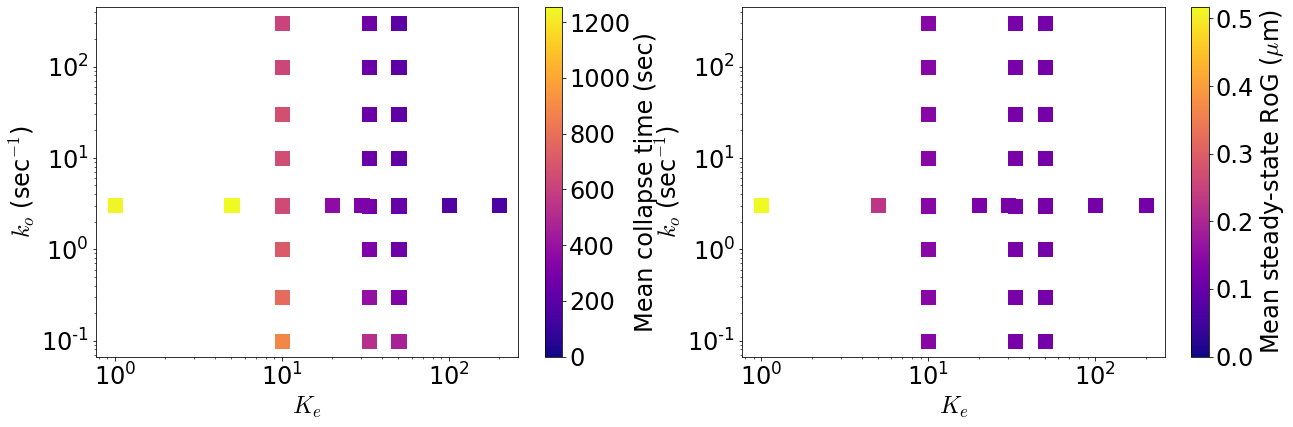

In [27]:
dpath_list = (ceph_path / "CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations", 
              ceph_path / "CondCharPaper/22-11-23_aLchr1_scan8.12_line800_Ke10_Ls55nm_kod.1-300/simulations",
              ceph_path / "CondCharPaper/22-11-23_aLchr1_scan8.12_line800_Ke50_Ls55nm_kod.1-300/simulations",
              ceph_path / "CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations")
ss_ind = 0
end_ind = -1
start_bead = 0
end_bead = None
ss_rog_avg_start_ind = -600
fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
data = collapse_size_phase_diagram(fig, axarr, dpath_list,
                                   ['Ke', 1], ['ko_d', 1], 
                                   scale_mark_size=False)

fig.tight_layout()
axarr[0].set_xscale('log')
axarr[0].set_yscale('log')
for ax in axarr:
    _ = ax.set_xlabel('$K_e$')
    _ = ax.set_ylabel('$k_o$ (sec$^{-1}$)')